# I. Preparing the data

In [28]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2
import imutils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [29]:
listOfFiles = os.listdir('masks')

def random_image(debug = False):
    file = 'masks/'+listOfFiles[np.random.randint(0,792)]
    if debug == True: print(file)
    return file

In [30]:
landmarks = pd.read_csv('data.csv')
landmarks['location'] = landmarks['location'].str.replace("'",'"')
landmarks = landmarks.join(landmarks['location'].apply(json.loads).apply(pd.Series))

In [31]:
landmarks

,photo_name,value,location,type,data
0,id_53_value_595_825.jpg,595.825,"{""type"": ""polygon"", ""data"": [{""x"": 0.30788, ""y...",polygon,"[{'x': 0.30788, 'y': 0.30207}, {'x': 0.30676, ..."
1,id_553_value_65_475.jpg,65.475,"{""type"": ""polygon"", ""data"": [{""x"": 0.26133, ""y...",polygon,"[{'x': 0.26133, 'y': 0.24071}, {'x': 0.31405, ..."
2,id_407_value_21_86.jpg,21.860,"{""type"": ""polygon"", ""data"": [{""x"": 0.27545, ""y...",polygon,"[{'x': 0.27545, 'y': 0.19134}, {'x': 0.37483, ..."
3,id_252_value_313_322.jpg,313.322,"{""type"": ""polygon"", ""data"": [{""x"": 0.21967, ""y...",polygon,"[{'x': 0.21967, 'y': 0.50845}, {'x': 0.70811, ..."
4,id_851_value_305_162.jpg,305.162,"{""type"": ""polygon"", ""data"": [{""x"": 0.06983, ""y...",polygon,"[{'x': 0.06983, 'y': 0.43491}, {'x': 0.34763, ..."
...,...,...,...,...,...
1239,id_255_value_172_542.jpg,172.542,"{""type"": ""polygon"", ""data"": [{""x"": 0.2368, ""y""...",polygon,"[{'x': 0.2368, 'y': 0.48755}, {'x': 0.74324, '..."
1240,id_878_value_97_299.jpg,97.299,"{""type"": ""polygon"", ""data"": [{""x"": 0.30909, ""y...",polygon,"[{'x': 0.30909, 'y': 0.55625}, {'x': 0.66163, ..."
1241,id_649_value_146_443.jpg,146.443,"{""type"": ""polygon"", ""data"": [{""x"": 0.20591, ""y...",polygon,"[{'x': 0.20591, 'y': 0.47059}, {'x': 0.67654, ..."
1242,id_396_value_228_944.jpg,228.944,"{""type"": ""polygon"", ""data"": [{""x"": 0.35106, ""y...",polygon,"[{'x': 0.35106, 'y': 0.59879}, {'x': 0.35162, ..."


In [32]:
landmarks['length'] = landmarks.apply(lambda row: len(row['data']), axis=1)

In [33]:
landmarks['digits'] = landmarks.apply(lambda row: 5 if (row['photo_name'].split('.')[0]).split('_')[-1]=='0' else 8, axis=1)

## I.1 Defining boxes

In [34]:
def annotate_boxes(file):
    
    n_digits = landmarks[landmarks['photo_name']==file.split('/')[1]]['digits'].values[0]
    
    decode = file.split('/')[-1].split('_')
    if decode[4].split('.')[0] == '0':
        n_digits = 5
        measurement = decode[3].zfill(5)
    else: 
        n_digits = 8
        measurement = (decode[3]+ decode[4].split('.')[0].zfill(3)).zfill(8)
            
    c_id = file.split('/')[-1].split('.')[0]
    
    gray = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    img = cv2.imread('images/'+file.split('/')[1])
    
    cnt = []
    contours = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    cnt = contours[0]
    
    # Calculating the box
    #--------------------------
    # cv2.boundingRect() returns (x,y) the top-left coordinate of the rectangle and (w,h) the width and height
    #--------------------------
    x_box,y_box,w_box,h_box = cv2.boundingRect(cnt)
    #cv2.rectangle(img,(x_box,y_box),(x_box+w_box,y_box+h_box),(0,255,0),2)
    area_bounding = w_box*h_box
            
    # Calculating the minimal box
    #--------------------------
    # cv2.minAreaRect() returns a Box2D structure ( center (x,y), (width, height), angle of rotation ). 
    #--------------------------
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    #cv2.drawContours(img,[box],0,(255,0,0),5)
    #area_min_rectangle = rect[1][0]*rect[1][1]
    
    
    box = box[np.argsort(box[:,0])]
    p_min_xy = box[1] if box[0,1] >  box[1,1] else box[0]
    box_ = box[np.array(np.abs(np.all(box == p_min_xy, axis = 1)-1), dtype=bool)]
    box_ = box_[np.argsort(box_[:,1])]
        
    if box_[0,0] > box_[1,0]:
        p_max_y_min_x, p_max_xy, p_min_y_max_x = box_[1], box_[2], box_[0] 
    else:
        p_max_y_min_x, p_max_xy, p_min_y_max_x = box_[0], box_[2], box_[1]

    if np.linalg.norm([p_min_xy, p_min_y_max_x]) > np.linalg.norm([p_min_xy,p_max_y_min_x]):
        angle = np.arctan(h_box/w_box)
        position = 'h'
        w = int(np.ceil(w_box/n_digits))
        x = x_box
        y = y_box
        h = h_box
        for i in range(0, n_digits):
            cv2.rectangle(img, (x,y),(x+w,y+h), (0,0,255-10*i),5)
            x += w                      
    else:
        ref = box[0] # reference point
        ver = box[1:,][np.argmin(box[1:,1])] # second vertice
        dif = ver-ref
        angle = np.degrees(np.arctan(dif[1]/dif[0]))
        if angle < 5: 
            angle = 0
        position = 'v'
        angle += 90   
        
        x = x_box
        y = y_box
        w = w_box #abs(p_min_y_max_x[0] - p_min_xy[0])
        h = int(np.ceil(abs(p_max_y_min_x[1]-p_min_xy[1])/n_digits))
        for i in range(0, n_digits):
            cv2.rectangle(img, (x,y),(x+w,y+h), (0,0,255),5)
            y += h    
    
    plt.rcParams["figure.figsize"] = (15,10)    
    plt.title('image')
    plt.axis("off")
    plt.imshow(img)

    return box, angle, p_min_xy, p_max_y_min_x, p_max_xy, p_min_y_max_x

masks/id_200_value_87_094.jpg
Wall time: 256 ms


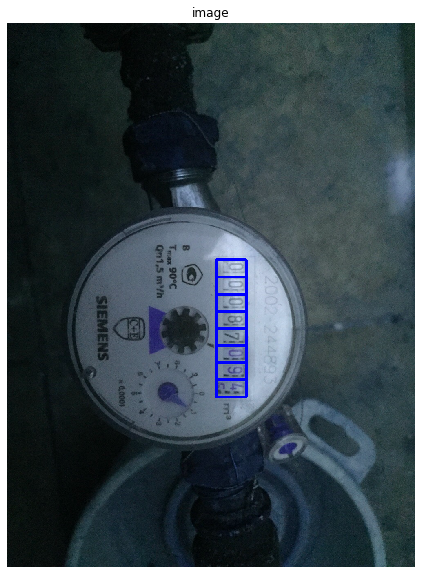

In [35]:
%%time
box, angle, p_min_xy, p_max_y_min_x, p_max_xy, p_min_y_max_x = annotate_boxes(random_image(True))

masks/id_1103_value_9_57.jpg
Wall time: 70.8 ms


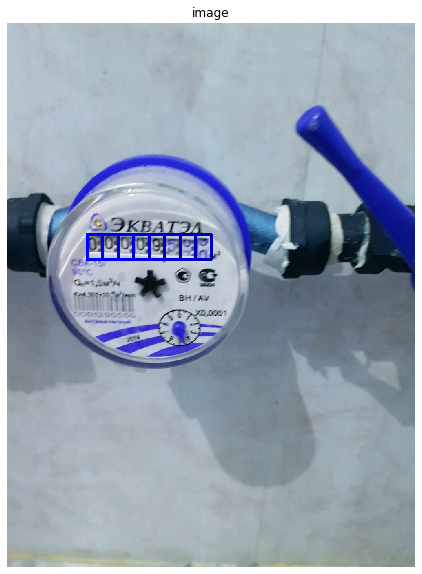

In [27]:
%%time
box, angle, p_min_xy, p_max_y_min_x, p_max_xy, p_min_y_max_x = annotate_boxes(random_image(True))

masks/id_499_value_113_563.jpg
Wall time: 75.9 ms


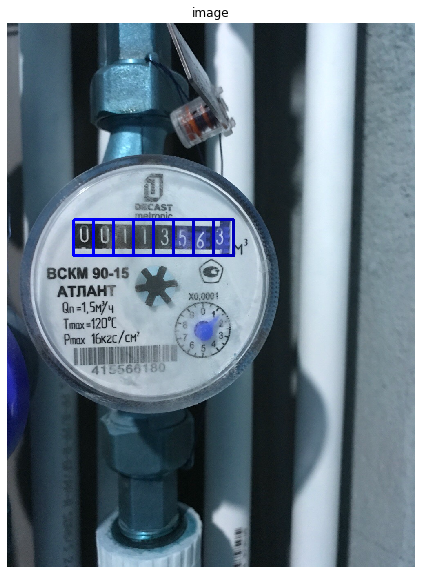

In [28]:
%%time
box, angle, p_min_xy, p_max_y_min_x, p_max_xy, p_min_y_max_x = annotate_boxes(random_image(True))

In [57]:
def generate_file_annotations(file, directory):
        
    decode = file.split('/')[-1].split('_')
    if decode[4].split('.')[0] == '0':
        n_digits = 5
        measurement = decode[3].zfill(5)
    else: 
        n_digits = 8
        measurement = (decode[3]+ decode[4].split('.')[0].zfill(3)).zfill(8)
            
    c_id = file.split('/')[-1].split('.')[0]
    
    gray = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    
    height, width = gray.shape
    
    cnt = []
    contours = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    cnt = contours[0]
    
    # Calculating the box
    #--------------------------
    # cv2.boundingRect() returns (x,y) the top-left coordinate of the rectangle and (w,h) the width and height
    #--------------------------
    x_box,y_box,w_box,h_box = cv2.boundingRect(cnt)
            
    # Calculating the minimal box
    #--------------------------
    # cv2.minAreaRect() returns a Box2D structure ( center (x,y), (width, height), angle of rotation ). 
    #--------------------------
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    
    box = box[np.argsort(box[:,0])]
    p_min_xy = box[1] if box[0,1] >  box[1,1] else box[0]
    box_ = box[np.array(np.abs(np.all(box == p_min_xy, axis = 1)-1), dtype=bool)]
    box_ = box_[np.argsort(box_[:,1])]
        
    if box_[0,0] > box_[1,0]:
        p_max_y_min_x, p_max_xy, p_min_y_max_x = box_[1], box_[2], box_[0] 
    else:
        p_max_y_min_x, p_max_xy, p_min_y_max_x = box_[0], box_[2], box_[1]

        
    if np.linalg.norm([p_min_xy, p_min_y_max_x]) > np.linalg.norm([p_min_xy,p_max_y_min_x]):
        w = int(np.ceil(w_box/n_digits))
        x = x_box
        y = y_box
        h = h_box
        for i in range(0, n_digits):
            x_center = int(x + w/2)
            y_center = int(y + h/2)
            gray = cv2.circle(gray, (x_center,y_center), radius=0, color=(0, 0, 255), thickness=20)
            x += w                      
    else:
        x = x_box
        y = y_box
        w = w_box 
        h = int(np.ceil(abs(p_max_y_min_x[1]-p_min_xy[1])/n_digits))
        for i in range(0, n_digits):
            x_center = int(x + w/2)
            y_center = int(y + h/2)
            gray = cv2.circle(gray, (x_center,y_center), radius=0, color=(0, 0, 255), thickness=20)
            y += h    
            
    print(height, width)
                
                
    plt.rcParams["figure.figsize"] = (15,10)    
    plt.title('image')
    plt.axis("off")
    plt.imshow(gray)


masks/id_23_value_203_248.jpg
1000 1333


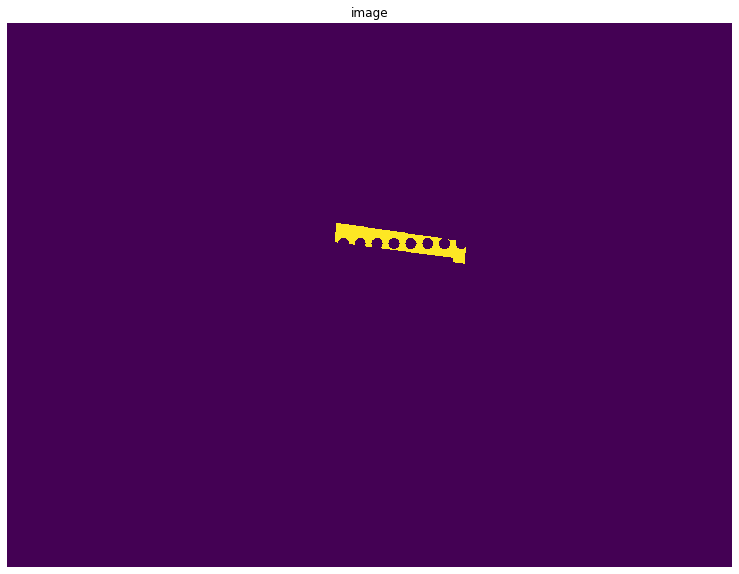

In [58]:
generate_file_annotations(random_image(True), '')

## I.2 Generating annotation files

#Number of digits - is used to define the number of boxes

It will create .txt-file for each .jpg-image-file - in the same directory and with the same name, but with .txt-extension, and put to file: object number and object coordinates on this image, for each object in new line:

<object-class> <x_center> <y_center> <width> <height>

Where:

<object-class> - integer object number from 0 to (classes-1)
<x_center> <y_center> <width> <height> - float values relative to width and height of image, it can be equal from (0.0 to 1.0]
for example: <x> = <absolute_x> / <image_width> or <height> = <absolute_height> / <image_height>
atention: <x_center> <y_center> - are center of rectangle (are not top-left corner)
For example for img1.jpg you will be created img1.txt containing:

In [52]:
def generate_file_annotations(file, directory):
        
    decode = file.split('/')[-1].split('_')
    if decode[4].split('.')[0] == '0':
        n_digits = 5
        measurement = decode[3].zfill(5)
    else: 
        n_digits = 8
        measurement = (decode[3]+ decode[4].split('.')[0].zfill(3)).zfill(8)
            
    c_id = file.split('/')[-1].split('.')[0]
    
    gray = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    
    height, width = gray.shape
    
    cnt = []
    contours = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    cnt = contours[0]
    
    # Calculating the box
    #--------------------------
    # cv2.boundingRect() returns (x,y) the top-left coordinate of the rectangle and (w,h) the width and height
    #--------------------------
    x_box,y_box,w_box,h_box = cv2.boundingRect(cnt)
            
    # Calculating the minimal box
    #--------------------------
    # cv2.minAreaRect() returns a Box2D structure ( center (x,y), (width, height), angle of rotation ). 
    #--------------------------
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    
    box = box[np.argsort(box[:,0])]
    p_min_xy = box[1] if box[0,1] >  box[1,1] else box[0]
    box_ = box[np.array(np.abs(np.all(box == p_min_xy, axis = 1)-1), dtype=bool)]
    box_ = box_[np.argsort(box_[:,1])]
        
    if box_[0,0] > box_[1,0]:
        p_max_y_min_x, p_max_xy, p_min_y_max_x = box_[1], box_[2], box_[0] 
    else:
        p_max_y_min_x, p_max_xy, p_min_y_max_x = box_[0], box_[2], box_[1]

        
    with open(directory+'/' + c_id +'.txt', 'w') as f:

        if np.linalg.norm([p_min_xy, p_min_y_max_x]) > np.linalg.norm([p_min_xy,p_max_y_min_x]):
            w = int(np.ceil(w_box/n_digits))
            x = x_box
            y = y_box
            h = h_box
            for i in range(0, n_digits):
                x_center = str((x + w/2)/width)
                y_center = str((y + h/2)/height)
                f.write(measurement[i]+' '+x_center+' '+y_center+' '+str(w/width)+' '+str(h/height)+'\n')
                x += w                      
        else:
            x = x_box
            y = y_box
            w = w_box 
            h = int(np.ceil(abs(p_max_y_min_x[1]-p_min_xy[1])/n_digits))
            for i in range(0, n_digits):
                x_center = str((x + w/2)/width)
                y_center = str((y + h/2)/height)
                f.write(measurement[i]+' '+x_center+' '+y_center+' '+str(w/width)+' '+str(h/height)+'\n')
                y += h    

In [53]:
generate_file_annotations(random_image(True),'data/water_meter/labels')

masks/id_1068_value_12_608.jpg


In [56]:
def generate_annotations(src, dst):
    
    listOfFiles = os.listdir(src)
    
    for file in listOfFiles:

        decode = file.split('_')
        if decode[4].split('.')[0] == '0':
            n_digits = 5
            measurement = decode[3].zfill(5)
        else: 
            n_digits = 8
            measurement = (decode[3]+ decode[4].split('.')[0].zfill(3)).zfill(8)

        c_id = file.split('.')[0]

        gray = cv2.imread(src+'/'+file, cv2.IMREAD_GRAYSCALE)

        height, width = gray.shape

        cnt = []
        contours = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = contours[0] if len(contours) == 2 else contours[1]
        contours = sorted(contours, key=cv2.contourArea, reverse=True)
        cnt = contours[0]

        # Calculating the box
        #--------------------------
        # cv2.boundingRect() returns (x,y) the top-left coordinate of the rectangle and (w,h) the width and height
        #--------------------------
        x_box,y_box,w_box,h_box = cv2.boundingRect(cnt)

        # Calculating the minimal box
        #--------------------------
        # cv2.minAreaRect() returns a Box2D structure ( center (x,y), (width, height), angle of rotation ). 
        #--------------------------
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)

        box = box[np.argsort(box[:,0])]
        p_min_xy = box[1] if box[0,1] >  box[1,1] else box[0]
        box_ = box[np.array(np.abs(np.all(box == p_min_xy, axis = 1)-1), dtype=bool)]
        box_ = box_[np.argsort(box_[:,1])]

        if box_[0,0] > box_[1,0]:
            p_max_y_min_x, p_max_xy, p_min_y_max_x = box_[1], box_[2], box_[0] 
        else:
            p_max_y_min_x, p_max_xy, p_min_y_max_x = box_[0], box_[2], box_[1]


        with open(dst+'/' + c_id +'.txt', 'w') as f:

            if np.linalg.norm([p_min_xy, p_min_y_max_x]) > np.linalg.norm([p_min_xy,p_max_y_min_x]):
                w = int(np.ceil(w_box/n_digits))
                x = x_box
                y = y_box
                h = h_box
                for i in range(0, n_digits):
                    x_center = str((x + w/2)/width)
                    y_center = str((y + h/2)/height)
                    f.write(measurement[i]+' '+x_center+' '+y_center+' '+str(w/width)+' '+str(h/height)+'\n')
                    x += w                      
            else:
                x = x_box
                y = y_box
                w = w_box 
                h = int(np.ceil(abs(p_max_y_min_x[1]-p_min_xy[1])/n_digits))
                for i in range(0, n_digits):
                    x_center = str((x + w/2)/width)
                    y_center = str((y + h/2)/height)
                    f.write(measurement[i]+' '+x_center+' '+y_center+' '+str(w/width)+' '+str(h/height)+'\n')
                    y += h

In [57]:
generate_annotations('masks', 'data/water_meter/labels')

## I.3 Splitting train and test

In [59]:
import glob
import os
import numpy as np
import sys
current_dir = "data/water_meter/images"
split_pct = 10  # 10% validation set
file_train = open("data/water_meter/train.txt", "w")  
file_val = open("data/water_meter/val.txt", "w")  
counter = 1  
index_test = round(100 / split_pct)  
for fullpath in glob.iglob(os.path.join(current_dir, "*.jpg")):  
    title, ext = os.path.splitext(os.path.basename(fullpath))
    if counter == index_test:
        counter = 1
        file_val.write(current_dir + "/" + title + '.jpg' + "\n")
    else:
        file_train.write(current_dir + "/" + title + '.jpg' + "\n")
        counter = counter + 1
file_train.close()
file_val.close()

## I.4 Training the neural network

In [ ]:
# Include train file here

## I.5 Testing Object Detection

In [5]:
from models import *
from utils import *

import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [16]:
config_path='config/yolov3.cfg'
weights_path='config/yolov3.weights'
class_path='config/coco.names'
img_size=416
conf_thres=0.8
nms_thres=0.4

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cuda()
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

In [17]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]

In [18]:
listOfImages = os.listdir('data/water_meter/images/')

def rand_image(debug = False):
    file = 'data/water_meter/images/'+listOfImages[np.random.randint(0,792)]
    if debug == True: print(file)
    return file

data/water_meter/images/id_1128_value_19_766.jpg
Inference Time: 0:00:00.136995


<Figure size 432x288 with 0 Axes>

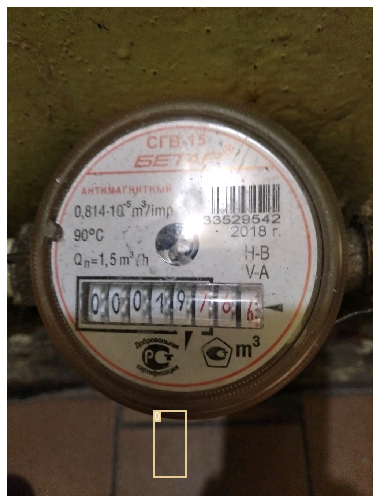

In [19]:
# load image and get detections
img_path = rand_image(debug = True)
prev_time = time.time()
img = Image.open(img_path)
detections = detect_image(img)
inference_time = datetime.timedelta(seconds=time.time() - prev_time)
print ('Inference Time: %s' % (inference_time))

# Get bounding-box colors
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

img = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    # browse detections and draw bounding boxes
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=classes[int(cls_pred)], color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
plt.axis('off')
# save image
#plt.savefig(img_path.replace(".jpg", "-det.jpg"), bbox_inches='tight', pad_inches=0.0)
plt.show()

In [38]:
torch.cuda.empty_cache()

In [39]:
torch.cuda.memory_allocated()

246865920

In [40]:
torch.cuda.max_memory_reserved()

769654784

In [ ]:
torch.cuda.max_memory_reserved()